In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from tqdm import tqdm
# import pandas as pd
# from scipy.optimize import curve_fit

# matplotlib styling
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = '12'
mpl.rc('image', cmap='gray')
# plt.style.use('gruvbox')

In [2]:
exp = np.exp
pi = np.pi
sqrt = np.sqrt
mpower = np.linalg.matrix_power
inv = np.linalg.inv
eig = np.linalg.eig
from scipy.linalg import block_diag

# Function definitions

In [3]:
def U_comp(k, kp, N):
    U0 = 0j
    for _ in range(N):
        U0 += (1/N)*exp(1j*(2*pi/N)*((kp-k+1)*(_+0.5)))
    return U0

def V_comp(k, kp, N):
    V0 = 0j
    if k == kp:
        return exp(1j*(2*pi/N)*(k+0.5))
    else:
        return V0

In [4]:
def F_kn(k, n, N):
    return (1/sqrt(N))*exp(-1j*(2*pi/N)*k*n)

def G_kn(k, n, N):
    return (1/sqrt(N))*exp(-1j*(2*pi/N)*(k+0.5)*(n+0.5))

In [5]:
def gen_mat(op, N):
    mat = np.matrix(np.zeros((N, N), dtype=complex))
    for i in range(N):
        for j in range(N):
            mat[i, j] += op(i, j, N)
    return mat

In [6]:
def harper_op(N):
    U = gen_mat(U_comp, N)
    V = gen_mat(V_comp, N)
    I = np.identity(N, dtype=complex)
    return 2*I - (U+U.H)/2 - (V+V.H)/2

In [7]:
def trans_op(p, q, N):
    U = gen_mat(U_comp, N)
    V = gen_mat(V_comp, N)
    return exp((1j*pi/N))*(mpower(U, p) @ mpower(inv(V), q))

In [8]:
# old version of bakers operator without certain symmetries
def baker_op__(N):
    assert N % 2 == 0
    F_n = gen_mat(F_kn, N)
    F_n2 = gen_mat(F_kn, N//2)
    return inv(F_n) @ block_diag(F_n2, F_n2)

# improved version of bakers operator with symmetries
def baker_op(N):
    assert N % 2 == 0
    G_n = gen_mat(G_kn, N)
    G_n2 = gen_mat(G_kn, N//2)
    return inv(G_n) @ block_diag(G_n2, G_n2)

In [9]:
def R_sym(N):
    return -1*mpower(gen_mat(G_kn, N), 2)

In [10]:
# returns row matrix of ground state of special harper operator
# used for generating coherent states
def psi_0(N, i=0):
    H_op = harper_op(N)
    evals, evecs = eig(H_op)
    idx = evals.argsort()
    evals = evals[idx]
    evecs = evecs[:, idx]
    return evecs[i]

In [11]:
# returns column matrix of |p,q> state
def pq_state(p, q, N):
    return trans_op(p, q, N) @ psi_0(N).T

In [12]:
def W_pq(p, q, N, psi):
    return ((1/N)*(np.abs(pq_state(p, q, N).T @ psi.T)**2))[0,0]

In [13]:
def W_pq_eff(N, psi):
    U = gen_mat(U_comp, N)
    Vinv = inv(gen_mat(V_comp, N))
    Wmat = np.zeros((N, N))
    psi01 = psi_0(N)
    for i in range(N):
        for j in range(N):
            Wmat[i, j] += ((1/N)*(np.abs(((exp((1j*pi/N)*i*j)*(mpower(U, i) @ mpower(Vinv, j))) @ psi01.T).T @ psi.T)**2))[0, 0]
    return Wmat


In [14]:
def RT_eff(N, T):
    U = gen_mat(U_comp, N)
    Vinv = inv(gen_mat(V_comp, N))
    RTmat = np.zeros((N, N))
    psi01 = psi_0(N)
    bakerop = baker_op(N)
    for _ in tqdm(range(N**2)):
        i = _ // N
        j = _ %  N
        pqst = ((exp((1j*pi/N)*i*j)*(mpower(U, i) @ mpower(Vinv, j))) @ psi01.T)
        RTmat[i, j] += ((1/N)*(np.abs(pqst.T @ mpower(bakerop, T) @ pqst)**2))[0, 0]
    return RTmat


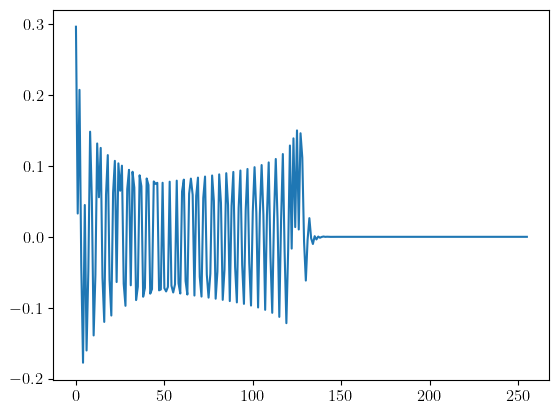

In [43]:
plt.plot(np.ravel(pq_state(0, 0, 256)))
plt.show()

100%|██████████| 4096/4096 [00:21<00:00, 192.56it/s]


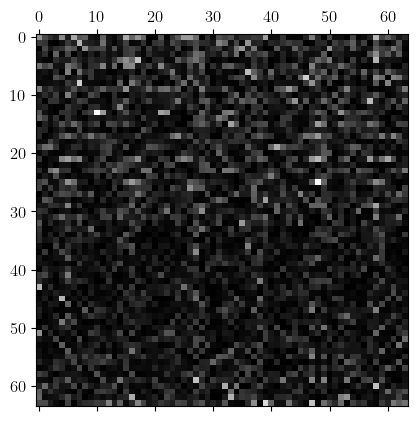

In [16]:
nd = 64
rt1 = RT_eff(nd, 1)
plt.matshow(rt1)
plt.show()

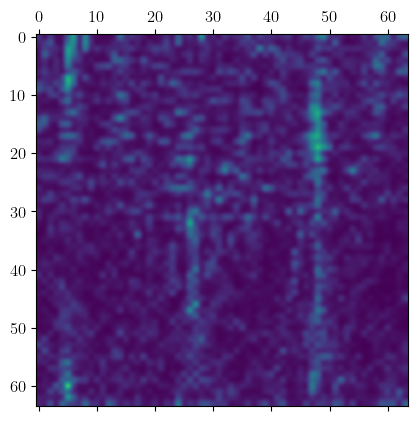

In [17]:
plt.matshow(rt1, cmap="viridis", interpolation="gaussian")
plt.show()

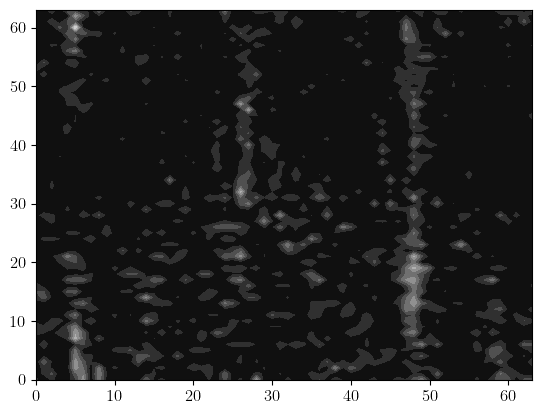

In [18]:
n = 64
x = np.arange(n)
y = np.arange(n)
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, rt1)
plt.show()